In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


## Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import math
import cv2
import scikitplot
import seaborn as sns
import matplotlib.pyplot as pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## Importing Dataset

In [12]:
df = pd.read_csv('../input/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Data Cleaning and EDA

In [13]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [14]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [15]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [16]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

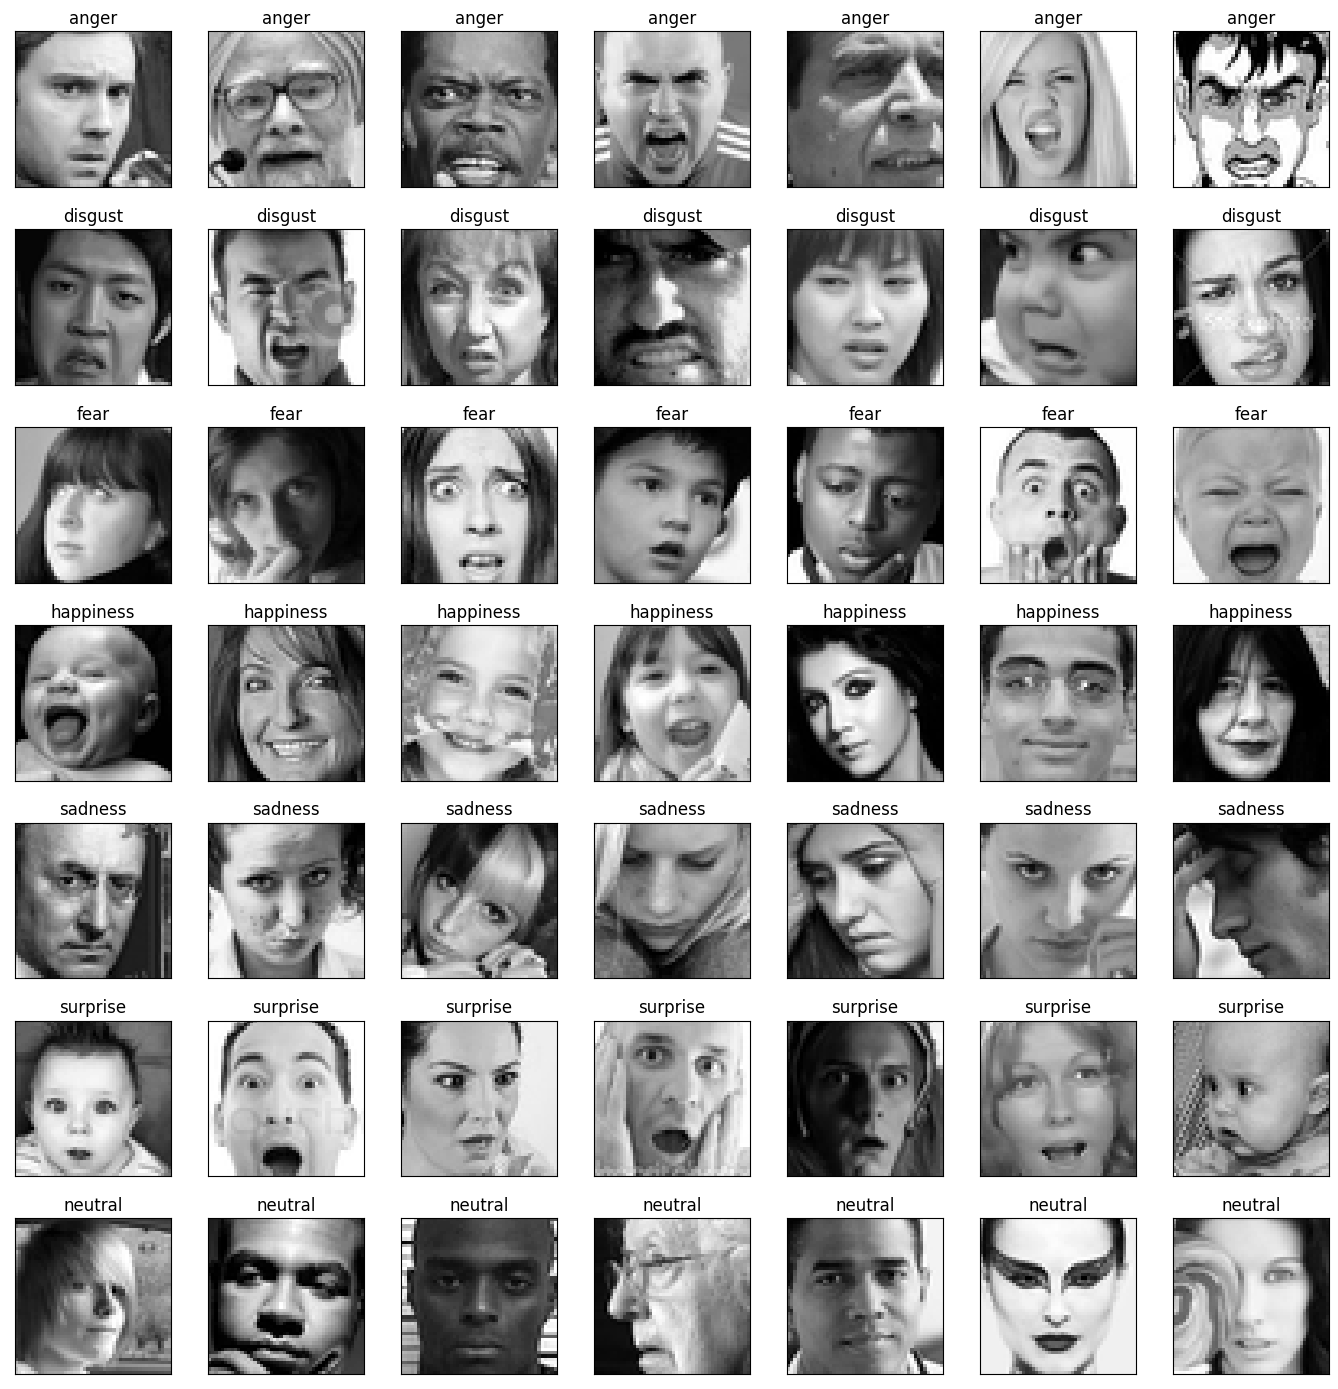

In [17]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

## Making data compatible for Neural Networks

In [18]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [19]:
img_array.shape

(35887, 48, 48)

In [20]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


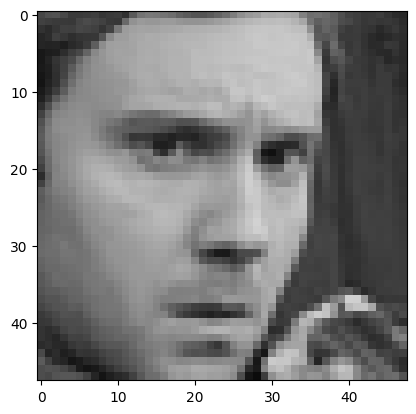

In [21]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [23]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [24]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


## Splitting the data into training and Validation set

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [26]:
del df
del img_features
del img_labels

In [27]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

**Normalizing results, as neural networks are very sensitive to unnormalized data.**

In [28]:
X_train = X_train / 255.
X_valid = X_valid / 255.

## VGG19 Model

In [32]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 4s 0us/step


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In [33]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [34]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [35]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## Callbacks

In [36]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

**As the data in hand is less as compared to the task so ImageDataGenerator is used**

In [37]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

## Training the model

In [38]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 15
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [39]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks
                                       )

Epoch 1/15
1009/1009 [==============================] - 52s 41ms/step - loss: 1.5008 - accuracy: 0.4067 - val_loss: 1.2452 - val_accuracy: 0.5227 - lr: 1.0000e-04
Epoch 2/15
1009/1009 [==============================] - 41s 40ms/step - loss: 1.2510 - accuracy: 0.5212 - val_loss: 1.1271 - val_accuracy: 0.5681 - lr: 1.0000e-04
Epoch 3/15
1009/1009 [==============================] - 39s 39ms/step - loss: 1.1696 - accuracy: 0.5570 - val_loss: 1.0895 - val_accuracy: 0.5924 - lr: 1.0000e-04
Epoch 4/15
1009/1009 [==============================] - 39s 39ms/step - loss: 1.1081 - accuracy: 0.5833 - val_loss: 1.0742 - val_accuracy: 0.6016 - lr: 1.0000e-04
Epoch 5/15
1009/1009 [==============================] - 40s 39ms/step - loss: 1.0604 - accuracy: 0.6023 - val_loss: 1.0043 - val_accuracy: 0.6227 - lr: 1.0000e-04
Epoch 6/15
1009/1009 [==============================] - 39s 39ms/step - loss: 1.0217 - accuracy: 0.6149 - val_loss: 1.0360 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 7/15
1009/1009 [

In [40]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

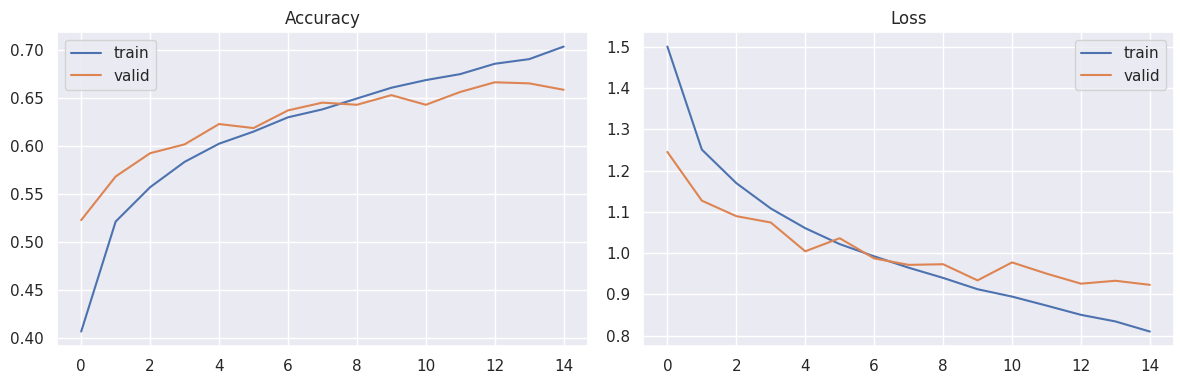

In [41]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

113/113 [==============================] - 1s 9ms/step
total wrong validation predictions: 1226


              precision    recall  f1-score   support

           0       0.57      0.62      0.59       495
           1       0.58      0.33      0.42        55
           2       0.57      0.43      0.49       512
           3       0.86      0.88      0.87       899
           4       0.62      0.42      0.50       608
           5       0.79      0.71      0.75       400
           6       0.52      0.80      0.63       620

    accuracy                           0.66      3589
   macro avg       0.64      0.60      0.61      3589
weighted avg       0.67      0.66      0.65      3589



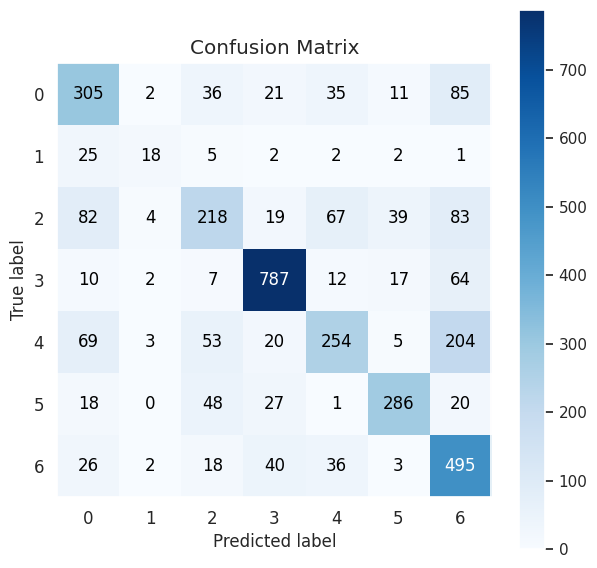

In [42]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [43]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

## Test Results on random images

1/1 [==============================] - 0s 24ms/step


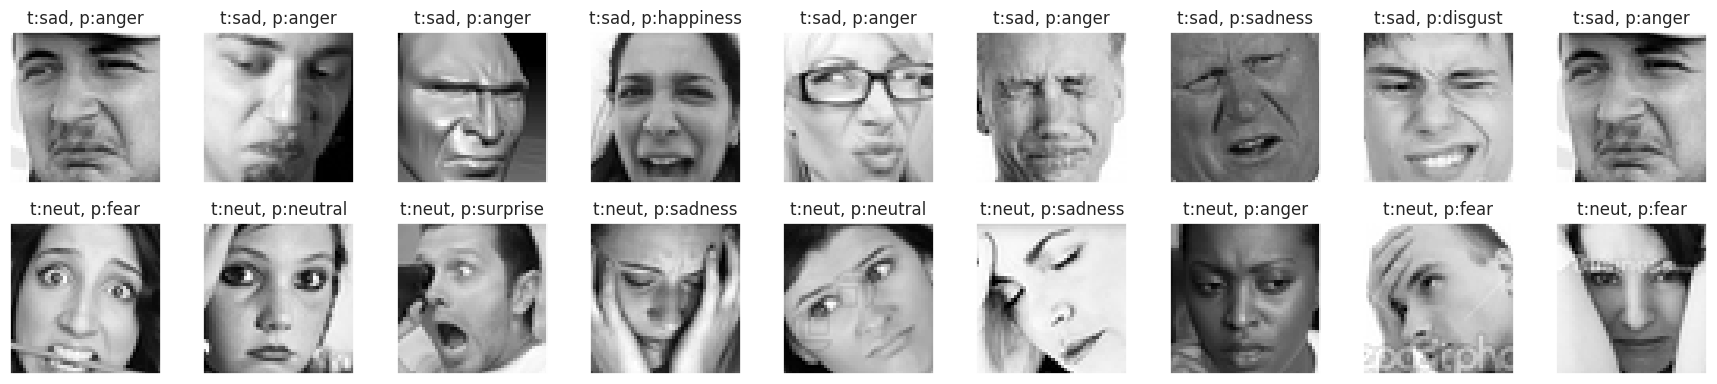

In [49]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"t:sad, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()